The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


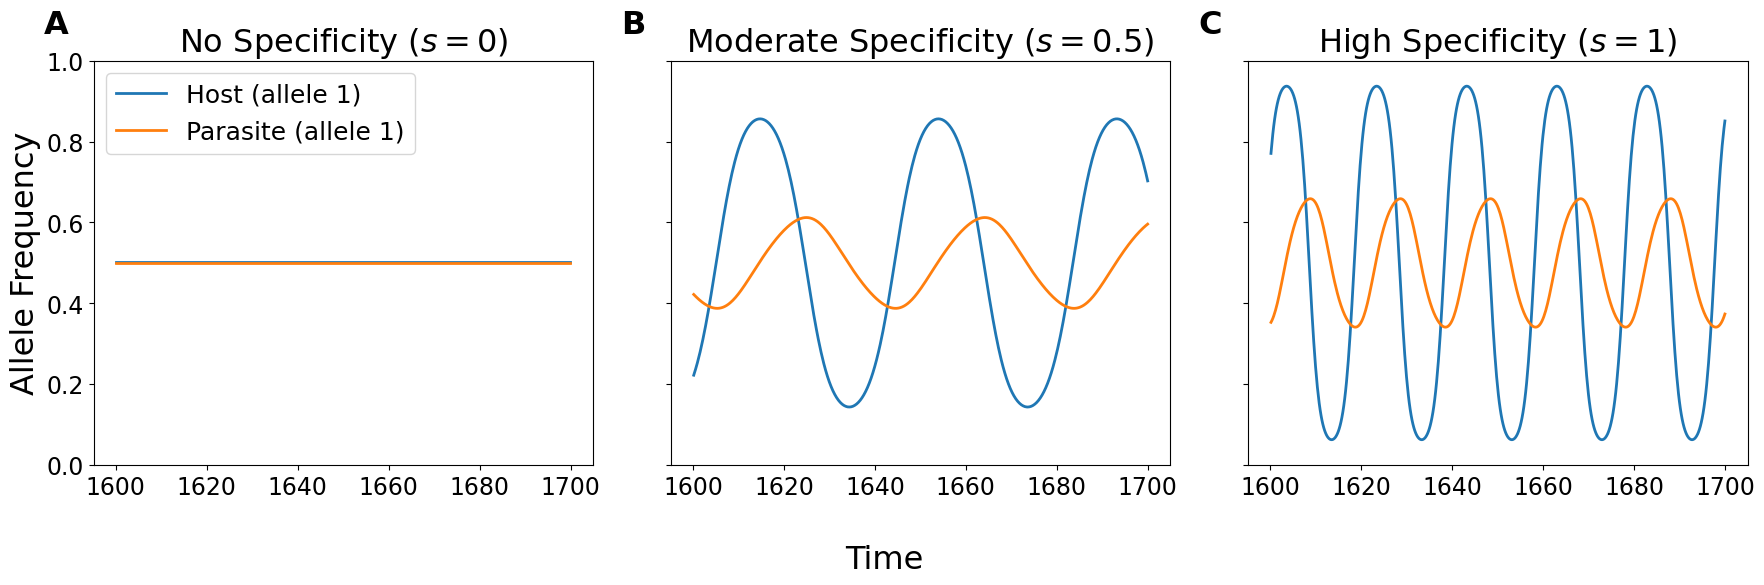

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# Default Parameter Values
d = 1.0
q = 1.0
b = 3.0
gamma = 1.0
alpha = 2.3
theta_tilde = 5.0
beta0 = 1.0
delta = 0.1 
n = 2
beta = beta0 * n
theta_k = theta_tilde * np.sqrt(alpha)

# infection matrix, Q
def create_infection_matrix(s, n=2):
    Q = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                Q[i, j] = (1 + (n - 1)*s) / n
            else:
                Q[i, j] = (1 - s) / n
    return Q

# ODE solver
def dydt(t, y, s):
    S1, S2, I11, I12, I21, I22, P1, P2 = y

    totalPop = S1 + S2 + I11 + I12 + I21 + I22

    Q = create_infection_matrix(s, n)

    dS1_dt = (b * S1 * (1 - q * totalPop)    # births
              - d * S1                       # natural death
              - beta * (Q[0, 0] * P1 + Q[0, 1] * P2) * S1  # new infections
              + gamma * (I11 + I12) )        # recoveries

    dS2_dt = (b * S2 * (1 - q * totalPop)
              - d * S2
              - beta * (Q[1, 0] * P1 + Q[1, 1] * P2) * S2
              + gamma * (I21 + I22) )

    dI11_dt = beta * Q[0, 0] * P1 * S1 - (d + gamma + alpha) * I11
    dI12_dt = beta * Q[0, 1] * P2 * S1 - (d + gamma + alpha) * I12
    dI21_dt = beta * Q[1, 0] * P1 * S2 - (d + gamma + alpha) * I21
    dI22_dt = beta * Q[1, 1] * P2 * S2 - (d + gamma + alpha) * I22

    dP1_dt = (theta_k * (I11 + I21)     # shedding from hosts infected by allele 1
              - delta * P1             # parasite decay
              - beta * (Q[0, 0] * S1 + Q[1, 0] * S2) * P1)  # loss to new infections

    dP2_dt = (theta_k * (I12 + I22) 
              - delta * P2
              - beta * (Q[0, 1] * S1 + Q[1, 1] * S2) * P2)

    return [dS1_dt, dS2_dt, dI11_dt, dI12_dt, dI21_dt, dI22_dt, dP1_dt, dP2_dt]

# initial conditions 
S1_0 = 1.01
S2_0 = 1.0
I11_0 = 0.1
I12_0 = 0.1
I21_0 = 0.1
I22_0 = 0.1
P1_0 = 0.1
P2_0 = 0.1

y0 = [S1_0, S2_0, I11_0, I12_0, I21_0, I22_0, P1_0, P2_0]

# Time span for the simulation
t_span = [0, 2000]
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# formatting
s_values = [0, 0.5, 1]
titles = ['No Specificity $(s=0)$', 'Moderate Specificity $(s=0.5)$', 'High Specificity $(s=1)$']
panel_labels = ['A', 'B', 'C']

plt.rcParams['font.size'] = 17
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 23 

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx in range(3):
    ax = axes[idx]
    s  = s_values[idx]

    sol = solve_ivp(lambda t, y: dydt(t, y, s), t_span, y0, t_eval=t_eval, method='RK45')

    t = sol.t
    S1, S2, I11, I12, I21, I22, P1, P2 = sol.y

    host_freq = (S1 + I11 + I12) / (S1 + S2 + I11 + I12 + I21 + I22)
    parasite_freq = P1 / (P1 + P2)

    start, end = 8000, 8500
    ax.plot(t[start:end], host_freq[start:end], linewidth=2, label='Host')
    ax.plot(t[start:end], parasite_freq[start:end], linewidth=2, label='Parasite')

    ax.annotate(f'{panel_labels[idx]}', xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=23, ha='left', va='bottom', fontweight='bold')

    ax.set_title(titles[idx])
    ax.set_ylim(0, 1)
    if idx == 0:
        ax.set_ylabel('Allele Frequency', fontsize=23)

fig.supxlabel('Time', fontsize=23)

axes[0].legend(['Host (allele 1)', 'Parasite (allele 1)'], loc='upper left', fontsize=18)

plt.tight_layout()
plt.savefig('time_series.eps', dpi=600, bbox_inches='tight')
plt.show()